# Trabalho - Simulação de um sistema não linear e suas caracteristicas

### Aluno:
- Nome: Felipe Fonseca Rocha
- Matrícula: 2015117096

---
## Exercício  1 -  Avaliação inicial do sistema
---

### Sistema escolhido
![tanques](tanques.png)

O modelo escolhido é o de controle de nível em dois tanques acoplados, sendo a definição das variáveis de estado:

$
\dot{y_1} = \frac{U_{in} - 2U_{12} + U_{out}}{A}
$

$
\dot{y_2} = \frac{U_{12} - U_{out}}{A}
$

Onde:

$
U_{12} = a_{12}\sqrt{2gu_1}
$

$
U_{out} = a_{2}\sqrt{2gu_2}
$

Sendo $y_1 = h_1$ e $y2 = h2$

Os parametros utilizados são

## Classificação do sistema

| Parâmetros   |    Valor             |
|:----------:|:-------------:       |
| $A$        |    $ 208 cm^3 $            |
| $a_2$        |    $ 0.24cm^2 $  |
| $a_{12}$        |    $ 0.58cm^2 $            |
| $U_{in}$        |    $ 0 < U_{in} < 50 cm^3 $            |

In [1]:
import math
import cmath
import random

import matplotlib as mpl
# from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
from scipy.fft import fft, fftfreq
import pandas as pd

import statsmodels.api as sm


plt.style.use('fivethirtyeight')
# plt.style.use('dark_background')
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['lines.linewidth'] = 2
#$\omega_n = A_1y_1^4 + B_1y_1³ + C_1 y_1² + D_1y_1 + E_1$

### Definição das equações de estado

In [2]:
def dvCord(x, ux, uy, t):
    # a = 0.258
    # b = 4.033
    # F = 8
    A= 208 #cm3
    a_2 = 0.24 #cm2
    a_12 =  0.58 #cm2
    U_in = (5 * ux + 20) if (5 * ux + 20) < 50 else 50
    g = 981 #cm/s2

    xd = np.array(np.zeros((2, 1)))

    U_12 = a_12 * math.sqrt( 2 * g * x[0] )
    U_out = a_2 * math.sqrt( 2 * g * x[1] )
    #
    # if U_out > 0 :
    #     print(f'Uin {U_in}; U_12 {U_12}, U_out {U_out}')

    U1 = (U_in - 2 * U_12 + U_out)
    U2 = (U_12 - U_out)
    xd[0] = U1 / A
    xd[1] = U2 / A
    return xd.copy()


### Definição de Runge-Kutta

In [3]:
def rk_cord(x0, ux, uy, h, t):
    # 1st evaluation
    xd = dvCord(x0, ux, uy, t)
    savex0 = x0.copy()
    phi = xd.copy()
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    # 2nd evaluation
    xd = dvCord(x0.T, ux, uy, t + 0.5 * h)
    phi = (phi + 2 * xd)
    for i in range(len(x0)):
        x0[i] = savex0[i] + 0.5 * h * xd[i]

    # 3rd evaluation
    xd = dvCord(x0, ux, uy, t + 0.5 * h)
    phi = phi + 2 * xd
    for i in range(len(x0)):
        x0[i] = savex0[i] + h * xd[i]

    # 4th evaluation
    xd = dvCord(x0, ux, uy, t + h)

    result_x = x0.copy()
    for i in range(len(x0)):
        result_x[i] = savex0[i] + (phi[i] + xd[i]) * h / 6

    # Restrição de nivel

    return result_x


### Plot das funções

In [4]:
def run_rk(t:np.ndarray, x:np.ndarray, u, h, cut=0 , mod=False):
    result = None
    for k in range(1, len(t)):
        result = rk_cord(x[:, k - 1].copy(), u[k], u[k], h, t[k])
        x[:, k] = result
    color = list(set(['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(100)]))
    set_color = random.sample(range(len(color)),3)
    fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 4))
    ax0 = ax.twinx()

    ax.set(xlabel='Time $(s \\cdot 10^{-2})$', xticks=(np.arange(0, len(t)/100, 1)))
    if mod:
        bottom = (min(u[cut:]) + 4) *.99
        top =  (max( u[cut:]) + 4)*1.01
        ax.set(ylabel='Tensão (V)',ylim=(bottom, top),yticks=(np.arange(bottom, top, (top-bottom)/10)))
    else:
        # ylim=((min(u[cut:]) * .9 + 4), (max( u[cut:]) * 1.1 + 4))
        ax.set(ylabel='Tensão (V)')

    p1, = ax.plot(t[cut:]/100, u[cut:]+4, 'g-', label='Entrada')
    # fig0, ax0 = plt.subplots(constrained_layout=True, figsize=(8, 4))
    ax0.set(xlabel='time')
    if mod:
        bottom = (min(x[1, cut:]) *.99)
        top = (max( x[1, cut:]) * 1.01)
        ax0.set(ylabel='Nível ($cm^3$)',ylim=(bottom,top),yticks=(np.arange(bottom, top, (top-bottom)/10)))
    else:
        ax0.set(ylabel='Nível ($cm^3$)',ylim=((min(x[1, cut:]) * .9), (max( x[1, cut:]) * 1.1)))
    # ax0.plot(t, x[0, :], color=color[set_color[1]],label='$H_1$')
    p2, = ax0.plot(t[cut:]/100, x[1, cut:], 'r-' ,label='$H_2$')
    lines = [p1,p2]
    ax.legend(lines, [l.get_label() for l in lines])
    ax.yaxis.label.set_color(p1.get_color())
    tkw = dict(size=10, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax0.yaxis.label.set_color(p2.get_color())
    ax0.tick_params(axis='y', colors=p2.get_color(), **tkw)
    ax.tick_params(axis='x', **tkw)
    plt.grid(which='both', axis='both', linestyle='--')


    # fig2, ax2 = plt.subplots(constrained_layout=True, figsize=(8, 4))
    # ax2.set(xlabel='time')
    # ax2.set(ylabel='x_3')
    # ax2.plot(t, x[2, :], color=color[random.randint(0, len(color) - 1)])
    # ax2.grid()
    # plt.xticks(np.arange(0, len(t)/100, 2))
    plt.show()

### Definições dos parâmetros
 Paramêtros da simulação são os tempos de resposta em segundos:

In [5]:
t0 = 0
tf = 1500
h = 1
t = np.arange(t0, tf, h)

# [print(i) for i in t if i < 0.1]

x0 = np.array([[.5], [8]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)

print(x)

[[0.5 0.  0.  ... 0.  0.  0. ]
 [8.  0.  0.  ... 0.  0.  0. ]]


### Resposta ao Degrau ponto de operação de de 8 e 8

L: 150; R: 1350


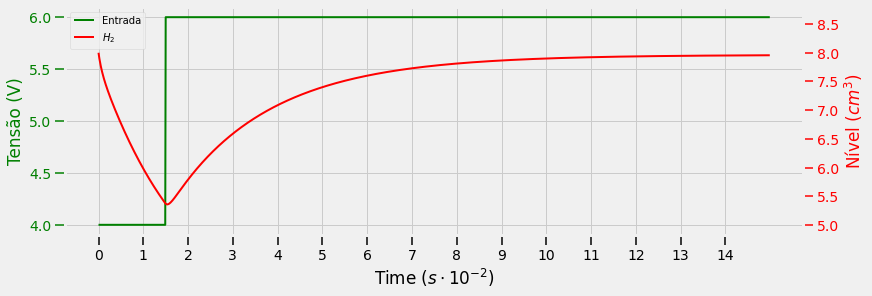

In [6]:
# Degrau
left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
u = 2 * np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h)


### Resposta ao Impulso
Imperceptivel devido a unidade de medida do sistema

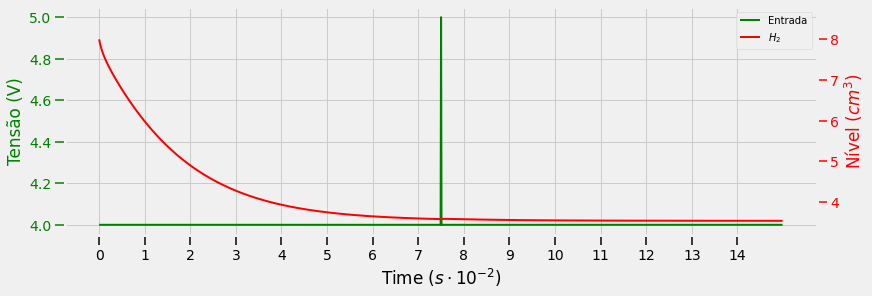

In [7]:
u = signal.unit_impulse(len(t),'mid')
run_rk(t.copy() ,x.copy(), u.copy() , h)

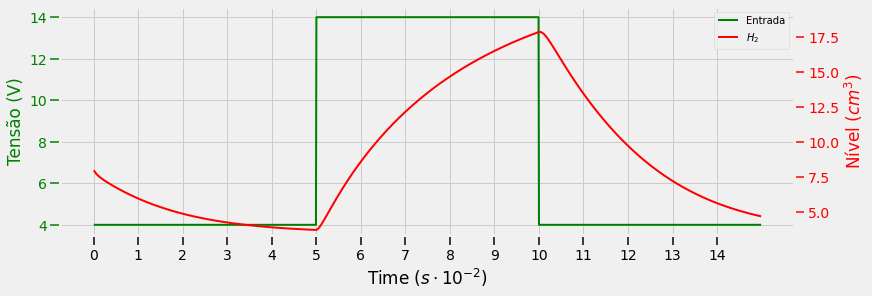

In [8]:
# Pulso
u = 10 * np.append(np.append(np.zeros((math.floor(len(t)/3), 1)), np.full((math.floor(len(t)/3), 1), 1)), np.zeros((math.floor(len(t)/3), 1)))
run_rk(t.copy() ,x.copy(), u.copy() , h)

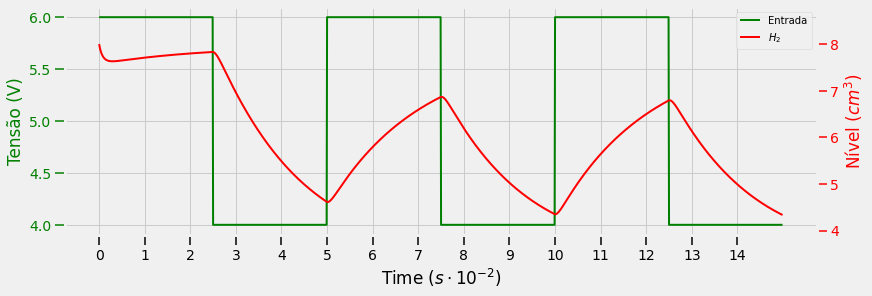

In [9]:
# Pulso
u = 1 * (signal.square(2 * np.pi * .002 * t)+1)
run_rk(t.copy() ,x.copy(), u.copy() , h)

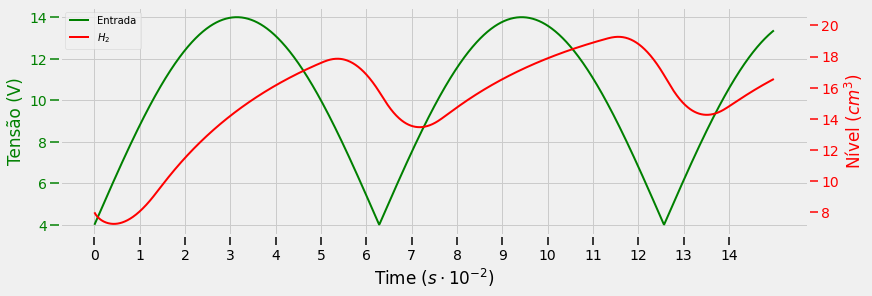

In [10]:
# Senoidal
u = 10 * abs(np.sin(np.array( t * 0.005)))  # np.zeros((len(t), 1))
run_rk(t.copy() ,x.copy(), u.copy() , h)

## Prova de não linearidade

### Resposta ao Degrau com amplitudes diferentes
Caso o sistema fosse linear era de se esperar que o mesmo, ao receber uma entrada duas vezes maior, vesse sua amplitude
aumentada de mesma forma. Porém não é o observado, mesmo em estado estacionário

L: 150; R: 1350


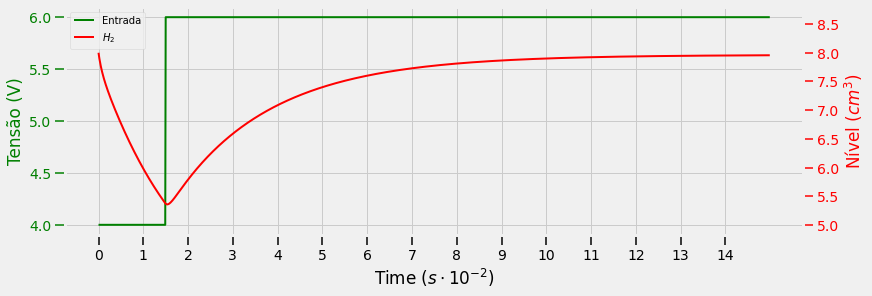

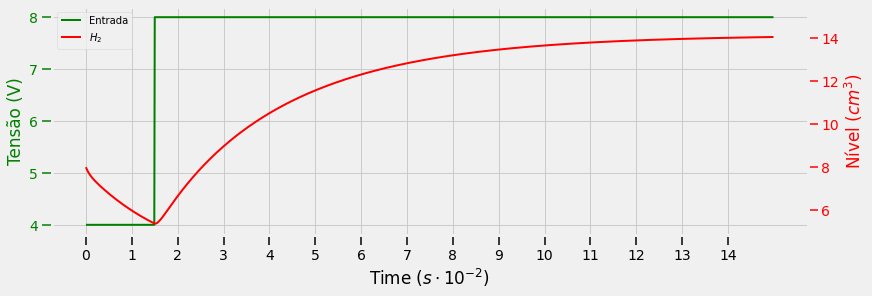

In [11]:
# Degrau
left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
u = 2 * np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h)
u = 4 * np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h)

### Resposta a sequência de pulsos de mesmo período e amplitude
Em diferentes níveis de tensão aplicados a bomba é possível visualizar no gráfico a resposta ao degrais
de mesmo período e amplitude tendo respostas bem diferentes do sistema. Essas diferenças se devem a pontos de operaçôes
distintos.

[0. 0. 0. ... 8. 8. 8.]


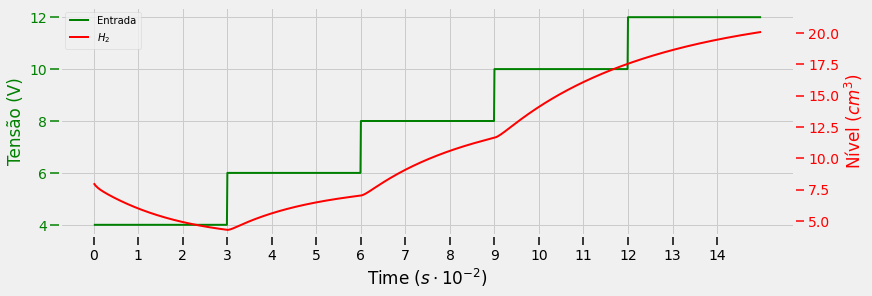

SEQUENCE


In [12]:
# Sequencia de Degrau
level = np.arange(0, 10, 2)
width = math.floor(len(t)/len(level))
ones = np.ones((1,width))
arr = [ level[i] * j  for i in range(len(level)) for j in ones]
u = np.array((arr)).flatten()
print(u)
run_rk(t.copy() ,x.copy(), u.copy() , h)
print("SEQUENCE")

L: 150; R: 1350


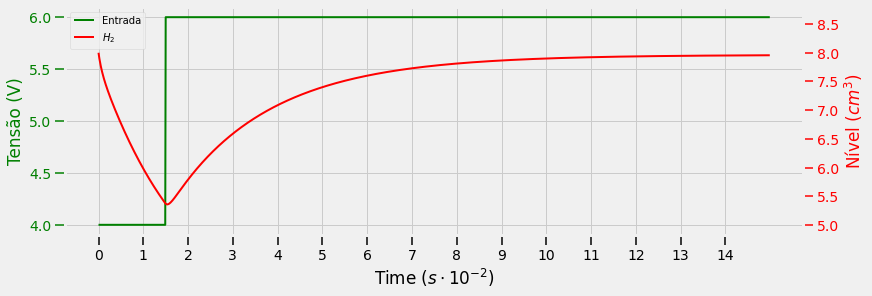

In [13]:
# Degrau
left_size = math.floor(len(t)/10)
right_size = math.floor(len(t) - len(t)/10)
print(f'L: {left_size}; R: {right_size}')
left = np.zeros((left_size, 1))
right = np.ones(right_size)
# print(f'L: {left}; R: {right}')
u = 2 * np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h)


---
## Exercício 2 - Modelagem paramétrica e não paramétrica
---

### *Definição do ponto de operação*

In [14]:
t0 = 0
tf = 5000
h = 1
t = np.arange(t0, tf, h)

# [print(i) for i in t if i < 0.1]

x0 = np.array([[1], [8]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)

L: 2500; R: 2500


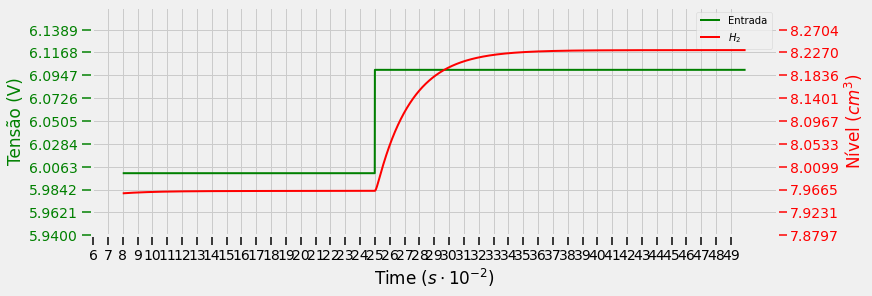

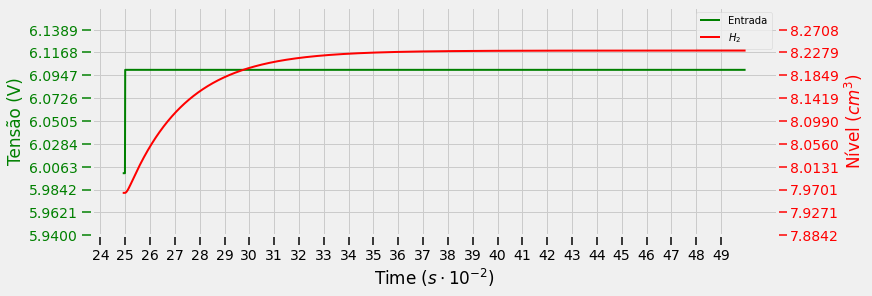

In [15]:
# Degrau
left_size = math.floor(len(t)/2)
right_size = math.floor(len(t) - len(t)/2)
print(f'L: {left_size}; R: {right_size}')
initial = 1
degree = 0.05
left = 2 * (np.zeros((left_size, 1)) + initial)
right = 2 * (np.ones(right_size) * degree + initial)
# print(f'L: {left}; R: {right}')
u = np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h, 800, True)
run_rk(t.copy() ,x.copy(), u.copy() , h, 2490, True)

### Aproximação por método deterministico para modelo de primeira ordem

Para modelar o atraso puro de tempo temos que:

In [16]:
degree1 = 0.1
print(f'U = {0.1}')
deltay = 8.2270-7.9665
print(f'Delta Y = {deltay}')
k = deltay/degree1
print(f'k = { deltay/0.1 }')

print(f'063 = {0.63 * deltay + 7.9665 }')

U = 0.1
Delta Y = 0.2605000000000004
k = 2.605000000000004
063 = 8.130615


$\Delta u = 0.1 $

$\Delta y = 8.227 - 7.967 $ = 0.261

Sendo $k = \frac{\Delta y}{\Delta u} = 2.61$

Outro valor necessário é $0.63\Delta y  + y_0 = 8.131$

Utilizando o ultimo valor obtido determinamos o tempo correspondente
para $ \delta = u_{y=8.131} - 2500 = 2750 - 2500 = 250$

Com isso temos que o modelo de 1ª ordem com atraso puro de tempo é:

$M_6(s) = \frac{2.61}{250s+1}$

In [17]:
def plot_graph(t:np.ndarray, x:np.ndarray, u, h, cut=0 , mod=False):
    color = list(set(['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(100)]))
    set_color = random.sample(range(len(color)),3)
    fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 4))
    ax0 = ax.twinx()
    t_aux = t+2490
    print(t_aux)
    ax.set(xlabel='Time $(s \\cdot 10^{-2})$')
    if mod:
        bottom = (min(u[cut:]) + 4) *.99
        top =  (max( u[cut:]) + 4)*1.01
        ax.set(ylabel='Tensão (V)',ylim=(bottom, top),yticks=(np.arange(bottom, top, (top-bottom)/10)))
    else:
        # ylim=((min(u[cut:]) * .9 + 4), (max( u[cut:]) * 1.1 + 4))
        ax.set(ylabel='Tensão (V)')

    p1, = ax.plot(t_aux[cut:]/100, u[cut:]+4, 'g-', label='Entrada')
    # fig0, ax0 = plt.subplots(constrained_layout=True, figsize=(8, 4))
    ax0.set(xlabel='time')
    if mod:
        bottom = (min(x[cut:]) + 8) *.99
        top = (max( x[cut:]) + 8) * 1.01
        ax0.set(ylabel='Nível ($cm^3$)',ylim=(bottom,top),yticks=(np.arange(bottom, top, (top-bottom)/10)))
    else:
        ax0.set(ylabel='Nível ($cm^3$)',ylim=(((min(x[cut:]) + 8 )* .9), ((max( x[cut:]) + 8 ) * 1.1)))
    # ax0.plot(t, x[0, :], color=color[set_color[1]],label='$H_1$')
    p2, = ax0.plot(t_aux[cut:]/100, x[cut:] + 8 , 'r-' ,label='$H_2$')
    lines = [p1,p2]
    ax.legend(lines, [l.get_label() for l in lines])
    ax.yaxis.label.set_color(p1.get_color())
    tkw = dict(size=10, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax0.yaxis.label.set_color(p2.get_color())
    ax0.tick_params(axis='y', colors=p2.get_color(), **tkw)
    ax.tick_params(axis='x', **tkw)
    plt.grid(which='both', axis='both', linestyle='--')


    # fig2, ax2 = plt.subplots(constrained_layout=True, figsize=(8, 4))
    # ax2.set(xlabel='time')
    # ax2.set(ylabel='x_3')
    # ax2.plot(t, x[2, :], color=color[random.randint(0, len(color) - 1)])
    # ax2.grid()
    # plt.xticks(np.arange(0, len(t)/100, 2))
    plt.show()

In [18]:
# Modelo de primeira ordem para ponto de operação 6V

tal = 250
k = 2.61
system_1 = signal.lti([0.1*k],[tal,1])
print(system_1)

TransferFunctionContinuous(
array([0.001044]),
array([1.   , 0.004]),
dt: None
)


L: 2500; R: 2990
[2490.         2490.58352784 2491.16705569 ... 4238.83294431 4239.41647216
 4240.        ]


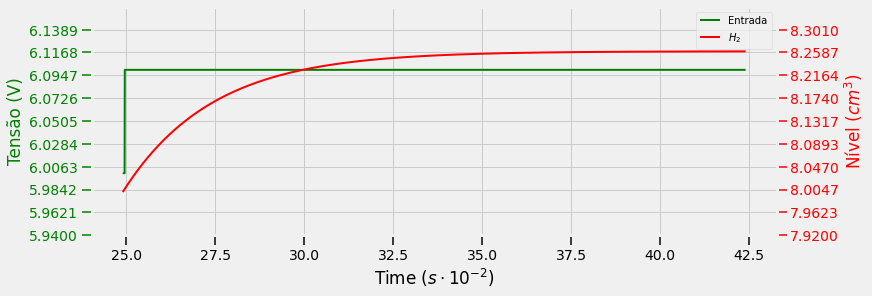

In [19]:
t1 , y1 = signal.step(system_1,N=3000)
right_size = math.floor(len(t1)-10)
print(f'L: {left_size}; R: {right_size}')
initial = 1
degree = 0.05
left = 2 * (np.zeros((10, 1)) + initial)
right = 2 * (np.ones(right_size) * degree + initial)
# print(f'L: {left}; R: {right}')
u = np.append(left,right)
plot_graph(t1,y1,u,1,0,True)


#### Análise dos resultados parciais
Devido ao não atraso de tempo para a resposta no modelo original do processo, ve-se que o modelo tem ajuste muito
próximo ao modelo originalo que permite trabalhar nesse ponto de operação com uma boa aproximação dos valores
obtidos pela modelo simulado de Runge-Kutta. Não havendo necessidade do ajuste de atraso puro no tempo para qualquer
acerto.

### Aproximação por Médoto de Sundaresan para modelo de segunda ordem:

Utilizanod ainda os valores de $k$ obtidos no item anterios, utilizou-se a reta entre o instante de tempo
2500 e 3000 para encontrar a area da curva, ficando:

$m_1 = 0 + \frac{500*0.261}{2} = 65$

$M_i = \frac{\Delta y}{\Delta t} = \frac{8.2270-7.9665}{250-0} = 0.001 $

$t_m = 250$

$\lambda = (t_m - m_1)Mi = 0.024$

$\eta = 0.095$

$\delta_1 =  \frac{\eta \cdot \frac{\eta}{1-\eta}}{M_i}  = 457,94$

$\delta_2 =  \frac{\eta \cdot \frac{1}{1-\eta}}{M_i} = 256,45$

$\delta_d =  m_1 - \delta_2 - \delta_1 =  -649,14$


Levando ao seguinte modelo:

$M_6(s) = \frac{2.61 \cdot e^{725,86}}{(947,44s+1)(28,42s+1)}$

TransferFunctionContinuous(
array([2.22243675e-06]),
array([1.00000000e+00, 6.08310144e-03, 8.51508332e-06]),
dt: None
)
L: 2500; R: 2990
[1840.86       1841.92889044 1842.99778087 ... 5044.32463816 5045.3935286
 5046.46241903]


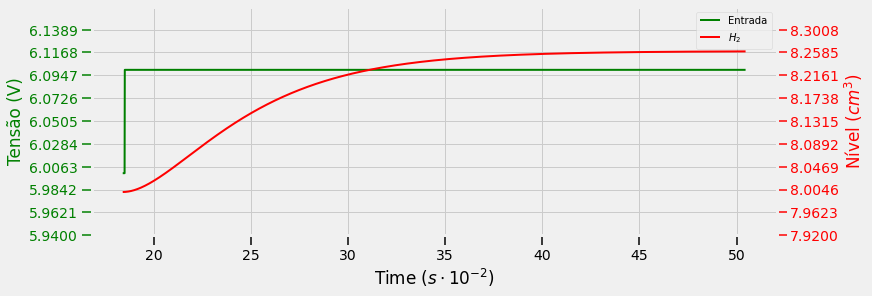

In [20]:
tal = 250
k = 0.261
system_2 = signal.lti([k],[117438.663,714.3913, 1])
print(system_2)

tal1=-649.14
t1 , y1 = signal.step(system_2,N=3000)
right_size = math.floor(len(t1)-10)
print(f'L: {left_size}; R: {right_size}')
initial = 1
degree = 0.05
left = 2 * (np.zeros((10, 1)) + initial)
right = 2 * (np.ones(right_size) * degree + initial)
# print(f'L: {left}; R: {right}')
u = np.append(left,right)
plot_graph(t1+tal1,y1,u,1,0,True)

#### Análise dos resultados parciais
Ainda pelo mesmo motivo ja discutido o modelo apresenta atraso no tempo, que foi ajustado para plotar. Ve-se que o
modelo tem ajuste muito próximo ao modelo original, porém com uma resposta significativamente mais lenta,isso se deve
as aproximações para utilização do método, que preve uma implexão na curva de resposta ao degrau do modelo original simulado,
dessa forma é necessário adptar o metodo para ainda conseguir alcançar o objetiovo da pratica.

Foram feitas algumas tentativas e o melhor resultado é apresentado acima. Os valores finais e o tempo para estabilidade ainda
permite trabalhar nesse ponto de operação com uma boa aproximação dos valores obtidos pela modelo simulado de Runge-Kutta.

### Validação em outro ponto de operação

#### Definições dos ponto de operação
 Paramêtros da simulação são os tempos de resposta em segundos:

[[ 8.  0.  0. ...  0.  0.  0.]
 [11.  0.  0. ...  0.  0.  0.]]
L: 2500; R: 2500


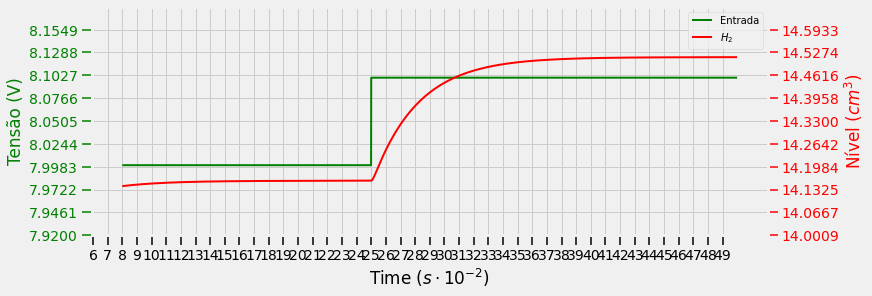

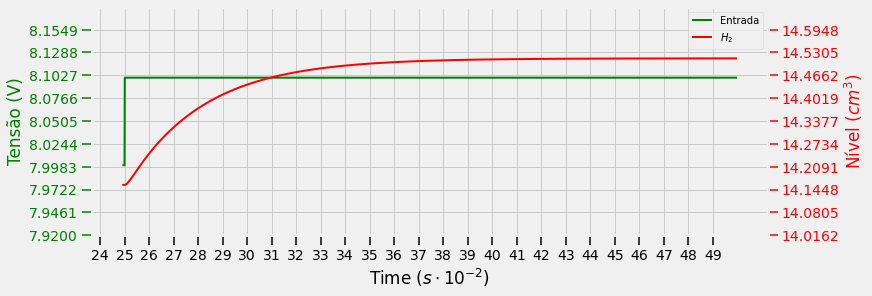

In [21]:
t0 = 0
tf = 5000
h = 1
t = np.arange(t0, tf, h)

# [print(i) for i in t if i < 0.1]

x0 = np.array([[8], [11]])

z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)

print(x)

# Degrau
left_size = math.floor(len(t)/2)
right_size = math.floor(len(t) - len(t)/2)
print(f'L: {left_size}; R: {right_size}')
initial = 2
degree = 0.05
left = 2 * (np.zeros((left_size, 1)) + initial)
right = 2 * (np.ones(right_size) * degree + initial)
# print(f'L: {left}; R: {right}')
u = np.append(left,right)
run_rk(t.copy() ,x.copy(), u.copy() , h, 800, True)
run_rk(t.copy() ,x.copy(), u.copy() , h, 2490, True)

In [22]:
def plot_graph1(t:np.ndarray, x:np.ndarray, u, cut=0 , mod=False):
    color = list(set(['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(100)]))
    set_color = random.sample(range(len(color)),3)
    fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 4))
    ax0 = ax.twinx()
    t_aux = t+2490
    print(t_aux)
    ax.set(xlabel='Time $(s \\cdot 10^{-2})$')
    if mod:
        bottom = (min(u[cut:]) + 4) *.99
        top =  (max( u[cut:]) + 4)*1.01
        ax.set(ylabel='Tensão (V)',ylim=(bottom, top),yticks=(np.arange(bottom, top, (top-bottom)/10)))
    else:
        # ylim=((min(u[cut:]) * .9 + 4), (max( u[cut:]) * 1.1 + 4))
        ax.set(ylabel='Tensão (V)')

    p1, = ax.plot(t_aux[cut:]/100, u[cut:]+4, 'g-', label='Entrada')
    # fig0, ax0 = plt.subplots(constrained_layout=True, figsize=(8, 4))
    ax0.set(xlabel='time')
    if mod:
        bottom = (min(x[cut:]) ) *.99
        top = (max( x[cut:]) ) * 1.01
        ax0.set(ylabel='Nível ($cm^3$)',ylim=(bottom,top),yticks=(np.arange(bottom, top, (top-bottom)/10)))
    else:
        ax0.set(ylabel='Nível ($cm^3$)',ylim=(((min(x[cut:]) + 8 )* .9), ((max( x[cut:])) * 1.1)))
    # ax0.plot(t, x[0, :], color=color[set_color[1]],label='$H_1$')
    p2, = ax0.plot(t_aux[cut:]/100, x[cut:], 'r-' ,label='$H_2$')
    lines = [p1,p2]
    ax.legend(lines, [l.get_label() for l in lines])
    ax.yaxis.label.set_color(p1.get_color())
    tkw = dict(size=10, width=1.5)
    ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
    ax0.yaxis.label.set_color(p2.get_color())
    ax0.tick_params(axis='y', colors=p2.get_color(), **tkw)
    ax.tick_params(axis='x', **tkw)
    plt.grid(which='both', axis='both', linestyle='--')


    # fig2, ax2 = plt.subplots(constrained_layout=True, figsize=(8, 4))
    # ax2.set(xlabel='time')
    # ax2.set(ylabel='x_3')
    # ax2.plot(t, x[2, :], color=color[random.randint(0, len(color) - 1)])
    # ax2.grid()
    # plt.xticks(np.arange(0, len(t)/100, 2))
    plt.show()

### Modelo 1º ordem

[14.15       14.15060849 14.15121557 ... 14.41076089 14.41076144
 14.410762  ]
[14.15       14.15000127 14.15000506 ... 14.41045781 14.41045907
 14.41046033]
[2490.         2490.58352784 2491.16705569 ... 4238.83294431 4239.41647216
 4240.        ]


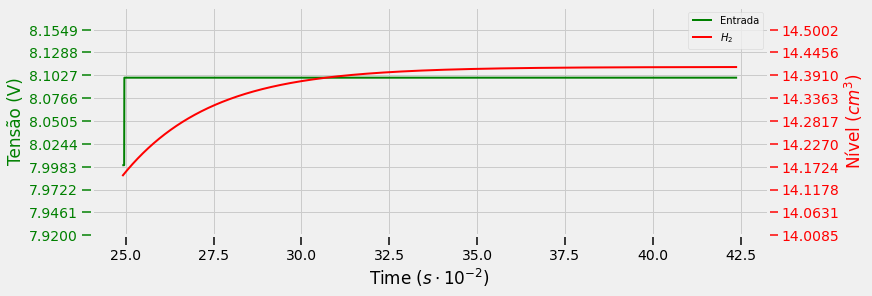

[2490.         2491.06889044 2492.13778087 ... 5693.46463816 5694.5335286
 5695.60241903]


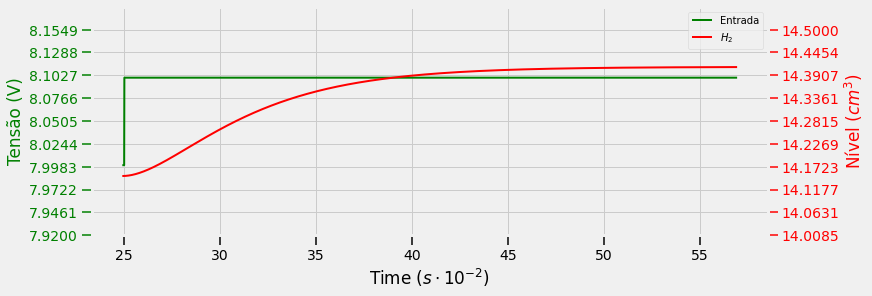

In [23]:
t1 , y1 = signal.step(system_1,N=3000)
t2 , y2 = signal.step(system_2,N=3000)
right_size = math.floor(len(t1) - 10)
initial = 2
degree = 0.05
left = 2 * (np.zeros((10, 1)) + initial)
right = 2 * (np.ones(right_size) * degree + initial)
u = np.append(left,right)
print(y1+14.15)
print(y2+14.15)
plot_graph1(t1,y1+14.15,u,0,True)
plot_graph1(t2,y2+14.15,u,0,True)


#### Analise

Como pode ser observado a resposta passa a ser insatisfatória no momento em que o ponto de operação não é mais o mesmo
independentemente do modelo utilizado.


### Diagrama de bode do sistema
#### Modelo de 1ª ordem obtido por metodo deterministico
O diagrama de bode pode ser visualizado abaixo e foi apresentado baseado no primeiro modelo de primeira ordem obtido.

In [24]:
def plot_bode(w,mag,phase):
    plt.figure(constrained_layout=True, figsize=(12, 4))
    plt.title('Diagrama de Amplitude $|H(j\omega)|$')
    plt.semilogx(w, mag)    # Bode magnitude plot
    plt.show()
    plt.figure(constrained_layout=True, figsize=(12, 4))
    plt.title(r'Diagrama de Fase $\alpha H(j\omega)$')
    plt.semilogx(w, phase)  # Bode phase plot
    plt.show()

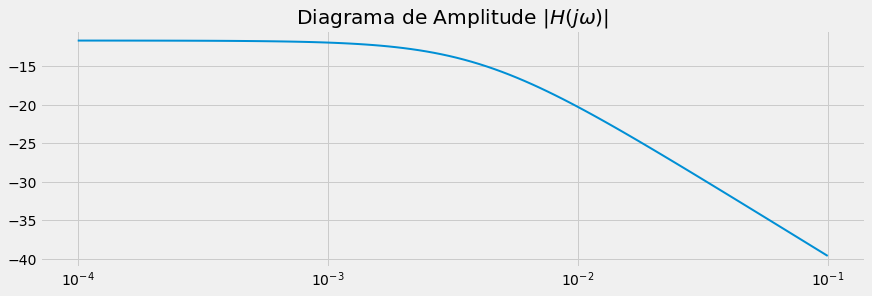

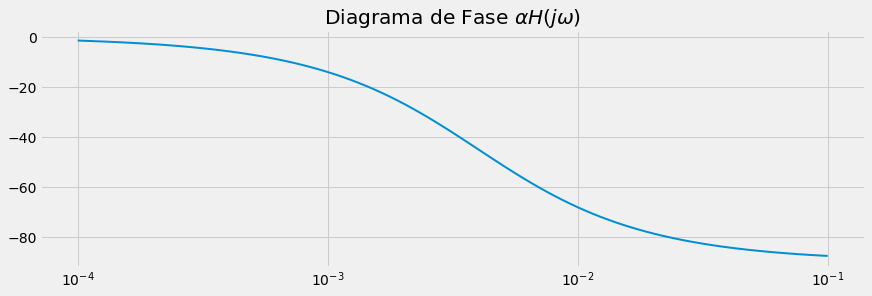

In [25]:
w, mag, phase = signal.bode(system_1)
plot_bode(w,mag,phase)


#### Modelo 2ª ordem obtido por Sundaresan

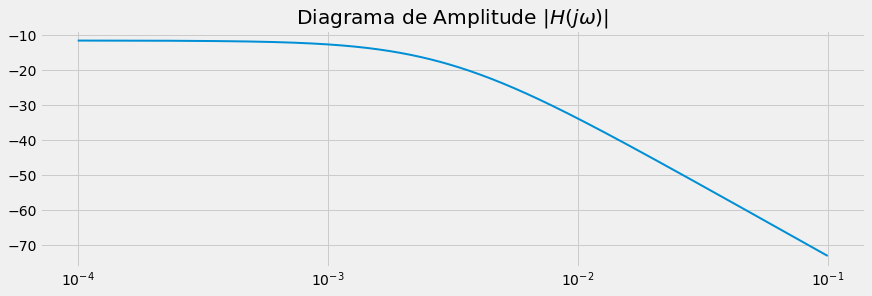

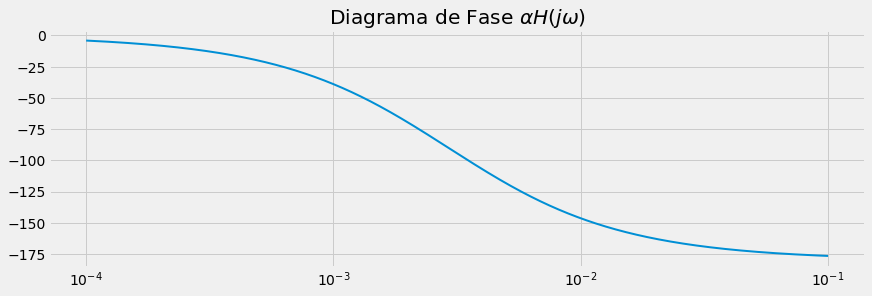

In [26]:
w, mag, phase = signal.bode(system_2, n=1359)
plot_bode(w,mag,phase)


---
## Exercício 3 -  Modelos paramétricos em um ponto de operação e Correlação
---

### Sinal PRBS e sinal Random Python

In [27]:
from tmsd_codes import *

In [28]:
def rand_signal(number_steps=1024):
    # random signal generation

    a_range = [0,2]
    a = np.random.rand(number_steps) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude

    b_range = [2, 10]
    b = np.random.rand(number_steps) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
    b = np.round(b)
    b = b.astype(int)

    b[0] = 0

    for i in range(1,np.size(b)):
        b[i] = b[i-1]+b[i]

    # Random Signal
    i=0
    random_signal = np.zeros(number_steps)
    while b[i]<np.size(random_signal):
        k = b[i]
        random_signal[k:] = a[i]
        i=i+1
    return random_signal.copy()          

In [29]:
random_signal = rand_signal()


t_prbs = np.arange(0, 1024,1)
u_prbs = prbs_signal(1024,10,10)


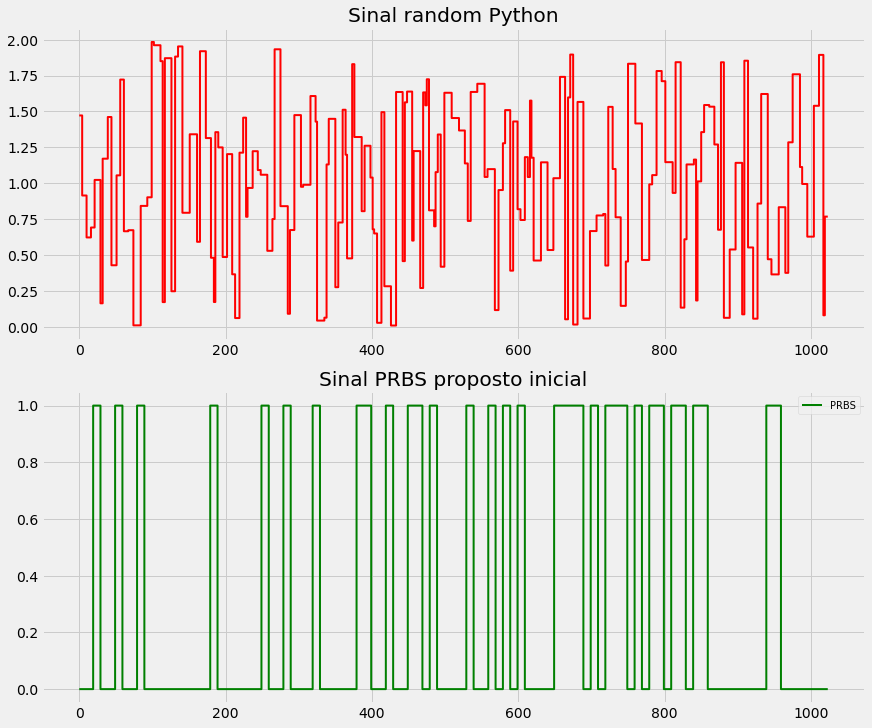

In [30]:
fig, ax = plt.subplots(2,1, constrained_layout=True, figsize=(12, 10))

ax[0].plot(random_signal, drawstyle='steps',label='Random Signal',color='r')
ax[0].set_title("Sinal random Python")
ax[1].plot(t_prbs,u_prbs, drawstyle='steps', label='PRBS', color='g')
ax[1].set_title("Sinal PRBS proposto inicial")
plt.legend()
plt.show()

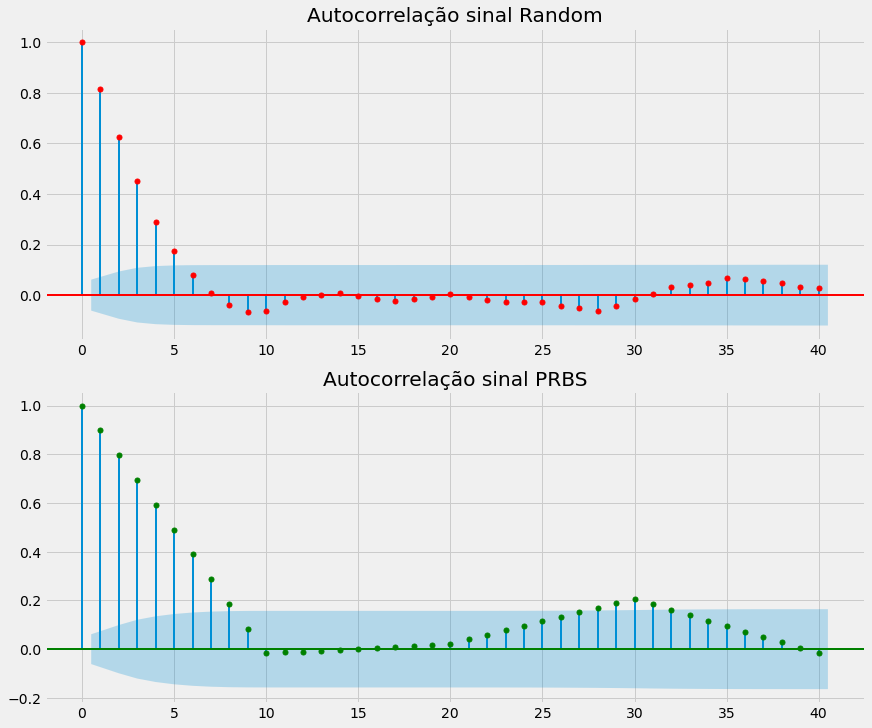

In [31]:
rand_dataframe = pd.DataFrame(random_signal)
prbs_dataframe = pd.DataFrame(u_prbs)
fig, ax = plt.subplots(2,1, constrained_layout=True, figsize=(12, 10))
sm.graphics.tsa.plot_acf(rand_dataframe.values.squeeze(), lags=40, color='r',alpha=0.05, ax=ax[0],title='Autocorrelação sinal Random')
sm.graphics.tsa.plot_acf(prbs_dataframe.values.squeeze(), lags=40, color='g',alpha=0.05, ax=ax[1],title='Autocorrelação sinal PRBS')
plt.show()

### Alteração do sinal para receber o valor  com erro de medição

#### 2 - alterando o sinal de saida após excitação com sinal PRBS

Considerando o $\delta_d = 250$ encontrado no exercício 2 para aproximações de modelo de primeira ordem e da Heuristica apresentado no vídeo do professor Aguirre para sistemas não lineares, tem se que $m = \delta_d$. E portanto:

L: 714; R: 4286


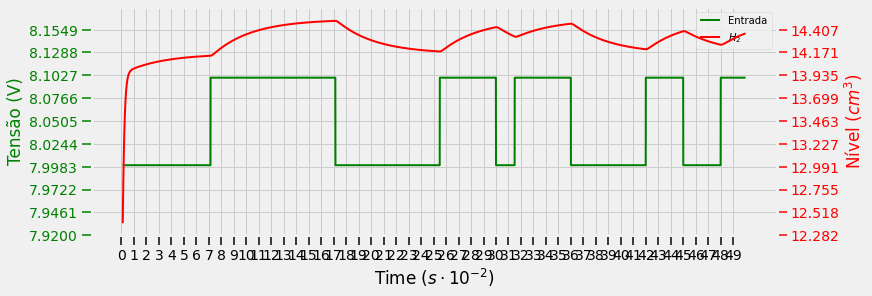

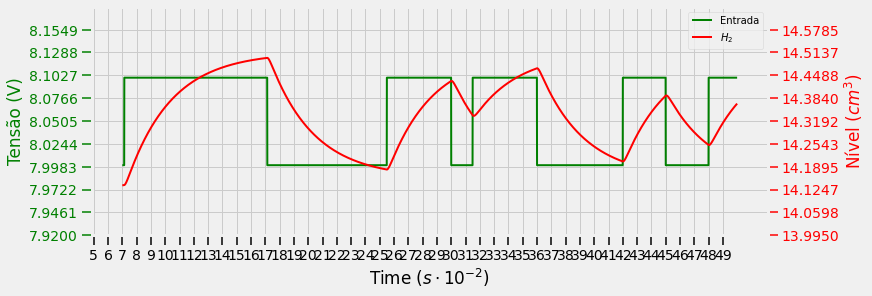

In [32]:
t0 = 0
tf = 5000
h = 1
t = np.arange(t0, tf, h)

x0 = np.array([[8], [11]])
z_x = np.zeros((len(x0), len(t) - 1))
x = x0.copy()
x = np.append(x, z_x, axis=1)

# Degrau
left_size = math.floor(len(t)/7)
right_size = math.floor(len(t) - len(t)/7)+1
print(f'L: {left_size}; R: {right_size}')
initial = 2
degree = 0.05
left = 2 * (np.zeros((left_size, 1)) + initial)
right = 2 * (np.ones(right_size) * degree + initial)
# print(f'L: {left}; R: {right}')
u = np.append(left,right)
random_signal = rand_signal()

## Definição de m para PRBS  
b = 10
N = tf
Td = 150
t_prbs = np.arange(0, tf, h)
u_prbs = prbs_signal(N, b, Td)*-1
u = u + ((u_prbs) * 0.1 * np.append(np.zeros((left_size+1000, 1)),np.ones(right_size-1000)))
run_rk(t.copy() ,x.copy(), u , h, 10, True)
run_rk(t.copy() ,x.copy(), u , h, 700, True)

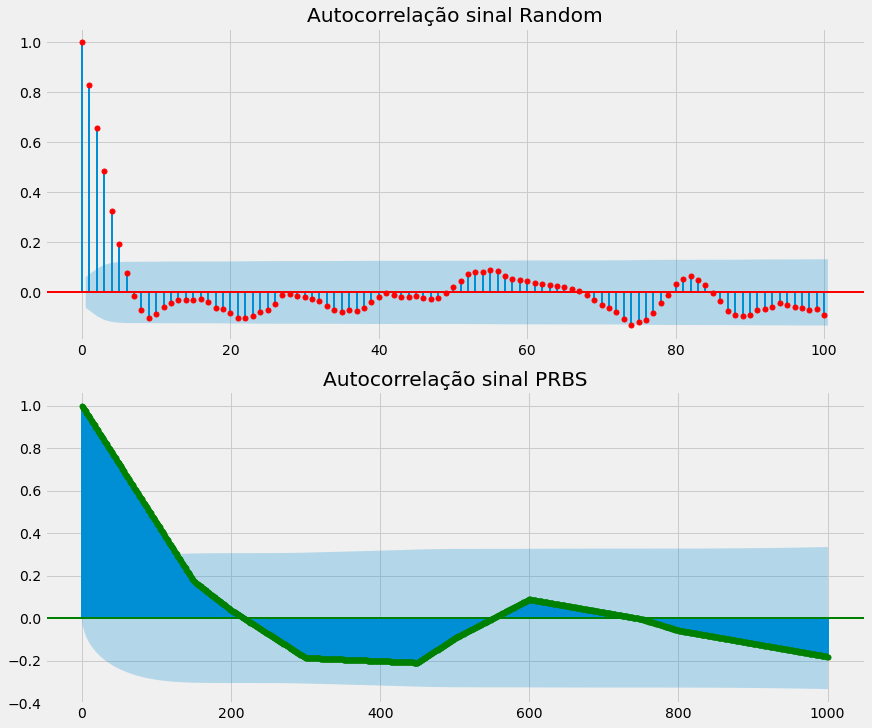

In [33]:
rand_dataframe = pd.DataFrame(random_signal)
prbs_dataframe = pd.DataFrame(u_prbs)
fig, ax = plt.subplots(2,1, constrained_layout=True, figsize=(12, 10))
sm.graphics.tsa.plot_acf(rand_dataframe.values.squeeze(), lags=100, color='r',alpha=0.05, ax=ax[0],title='Autocorrelação sinal Random')
sm.graphics.tsa.plot_acf(prbs_dataframe.values.squeeze(), lags=1000, color='g',alpha=0.05, ax=ax[1],title='Autocorrelação sinal PRBS')
plt.show()


Saída em estado estacionário do ponto de operação: 14.132570059695256



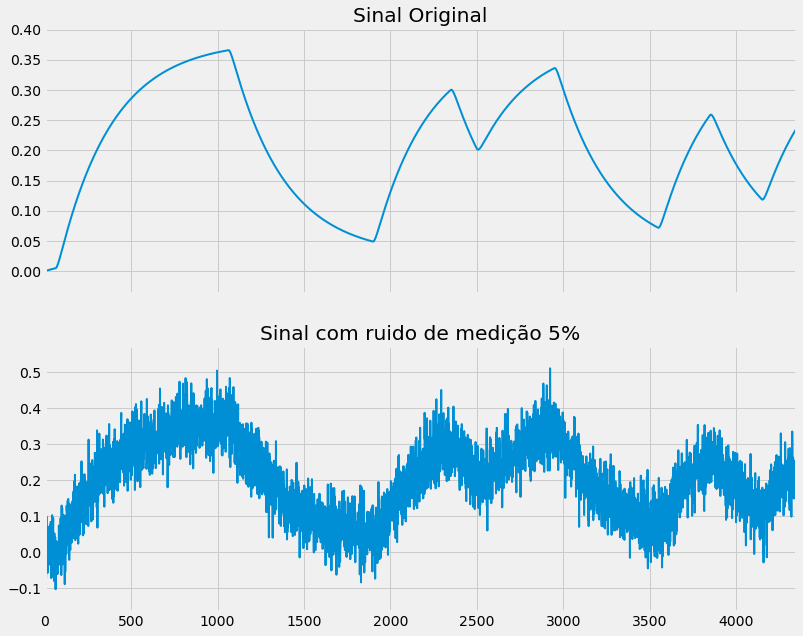

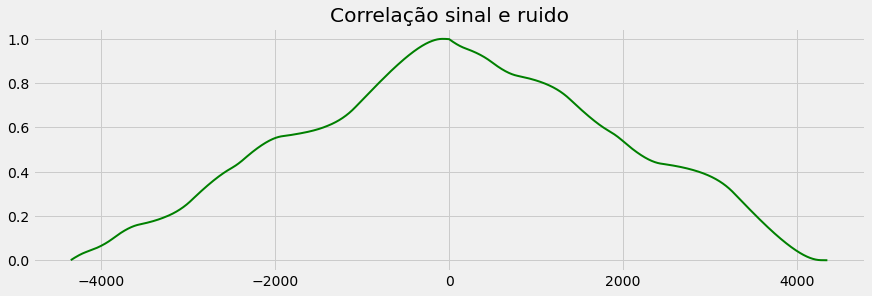

In [34]:
cut = 650

def run_rk_only(t:np.ndarray, x:np.ndarray, u, h):
    result = None
    for k in range(1, len(t)):
        result = rk_cord(x[:, k - 1].copy(), u[k], u[k], h, t[k])
        x[:, k] = result
    return x[1,cut:].copy()

sig = run_rk_only(t.copy() ,x, u , h)

print(f'\nSaída em estado estacionário do ponto de operação: {sig[0]}\n')

sig = sig - sig[0]
u_t=u[cut:]

# noise = 0.05 * np.random.randn(len(sig))
noise = np.random.normal(0,0.05,len(sig))

sig_noise = sig + noise 

corr = signal.correlate(u_t, sig)
lags = signal.correlation_lags(len(sig), len(sig_noise))
corr /= np.max(corr)

fig, (ax_orig, ax_noise) = plt.subplots(2, 1, sharex=True, figsize=(12, 10))
ax_orig.plot(sig)
# ax_orig.plot(clock, sig[clock], 'ro')
ax_orig.set_title('Sinal Original')
ax_orig.margins(0, 0.1)

ax_noise.plot(sig_noise)
# ax_corr.plot(clock, corr[clock], 'ro')
ax_noise.set_title('Sinal com ruido de medição 5%')
ax_noise.margins(0, 0.1)
plt.show()

plt.figure(constrained_layout=True, figsize=(12, 4))
plt.plot(lags, corr, label='Correlacao', color='g')
plt.title("Correlação sinal e ruido")
plt.show()

Utilizando a função sugerida pelo professor é possível observar a assimetria encontrada para correlação entre entrada e saída e também a simetria entre a correlação saída e ruído. Ambos esperados devido a natureza da relação sendo a primeira uma plicação de sinal a partir do lag 0 e outro o que não tem qualquer relação com o sinal anterior, e a segunda, tendo uma regra de aplicação (ainda que randomizada) de até 5% de ruído sobre o valor do sinal já existente.

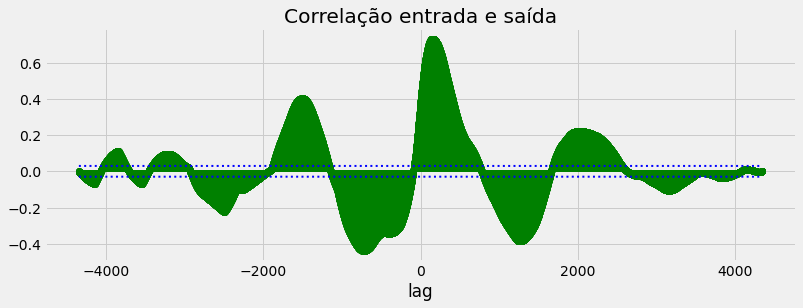

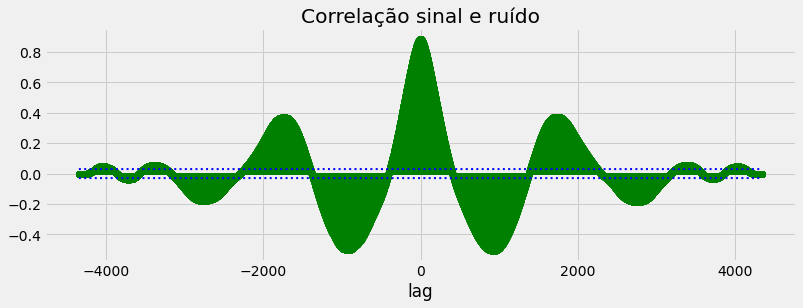

(array([-4350, -4349, -4348, ...,  4348,  4349,  4350]),
 array([ 2.01093729e-17,  7.94362176e-05,  2.11469683e-04, ...,
        -3.23795417e-04, -1.62312487e-04,  1.50820297e-17]),
 0.029717443308293016,
 0.010153421881516527)

In [35]:
myccf(y=sig,u=u_t,lag=len(u_t)*2,flag1=1,flag2=1, title="Correlação entrada e saída")
myccf(y=sig,u=sig_noise,lag=len(u_t)*2,flag1=1,flag2=1, title="Correlação sinal e ruído")


### Método de Wiener para estimação da resposta ao impulso

#### 3 - Aplicação do método 

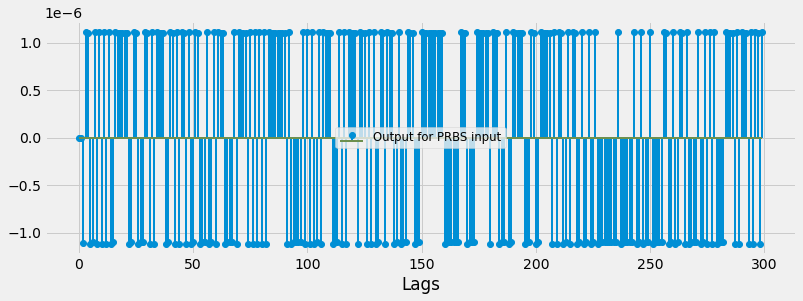

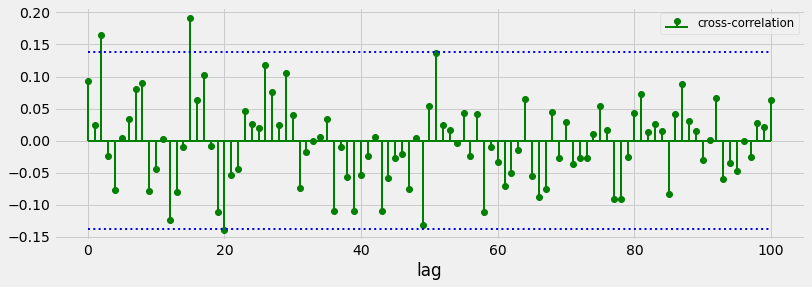

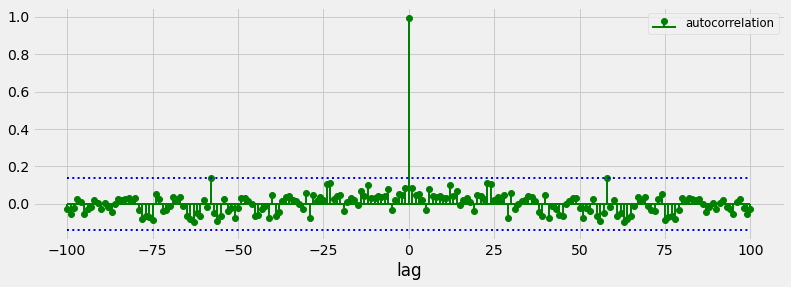

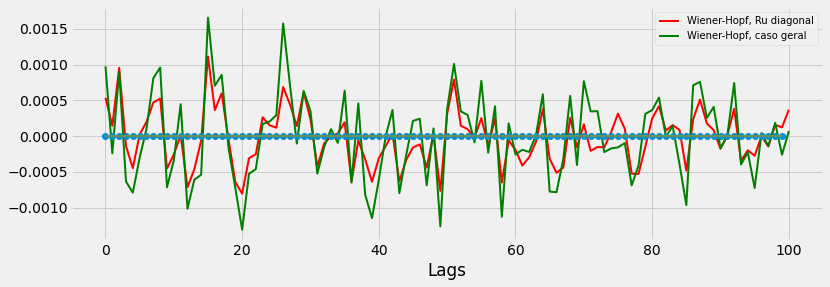

In [52]:

limit = 300
a_range = 200

# tf = signal.TransferFunction([k],[tal,-1],dt=1)
tf = signal.TransferFunction([k],[117438.663,714.3913, 1],dt=1)

u_t1 = prbs_signal(limit,10,1) - 0.5
t_prbs, y_prbs = signal.dlsim(tf, u_t1)

y_prbs = np.squeeze(y_prbs)
fig = plt.figure(figsize=(12, 4))
plt.stem(t_prbs, y_prbs, '-')
plt.legend(['Output for PRBS input'],loc='best', fontsize = 'small')
plt.xlabel('Lags')
plt.show()

e = np.random.rand(len(u_t1))
# ajustando variancia para aproximadamente 0,1
e = 0.01*(e - np.mean(e))

# Correlação cruzada entrada-saída
u_t2 = np.squeeze(u_t1)
t_ry, ruy, l, Bruy = myccf(y_prbs[limit-a_range:limit]+e[limit-a_range:limit],u_t2[limit-a_range:limit],len(u_t2[limit-a_range:limit])/2+1,0,1,legend = "cross-correlation")
# Autocorrelação entrada PRBS
t_ru, ru, l, Bru = myccf(u_t2[limit-a_range:limit],u_t2[limit-a_range:limit],len(u_t2[limit-a_range:limit]),1,1,legend = "autocorrelation")

# Estimando resposta ao impulso via Wiener-Hopf assumindo que a entrada eh perfeitamente 
# aleatoria, ou seja, Ruu diagonal, eq. (4.14) do livro.

u_var = np.var(u_t2,ddof =1)
h = ruy/u_var # h = ruy/Bru

fig = plt.figure(figsize=(12, 4))
p1, = plt.plot(h*Bruy, color = 'red', label = 'Wiener-Hopf, Ru diagonal')
plt.xlabel('Lags')

# Estimando resposta ao impulso via Wiener-Hopf sem assumir Ruu diagonal, 
# método de deconvolução.

rur = ru[::-1]*Bru #ru tem simetria par
index0 = int((len(rur)-1)/2)
Ru = rur[index0:]
for i in range(1,index0+1):
    newrow = rur[index0 - i:-i]
    Ru = np.vstack([Ru, newrow])
                            
Ru = np.matrix(Ru)
ruy_v = np.matrix(ruy)
Rui = np.linalg.inv(Ru)
Hm = np.inner(Rui,ruy_v)/500
p2, = plt.plot(t_ry,Hm, color = 'green', label = 'Wiener-Hopf, caso geral')

lines = [p1,p2]
plt.legend(lines, [l.get_label() for l in lines])

# Estimando resposta ao impulso simulando
t_imp, y_imp = signal.dimpulse(tf)
y_imp = np.squeeze(y_imp)
plt.stem(t_imp[0:], y_imp[0:], '-')
    
plt.show()

Para o Caso apresentado no trabalho a adequação do metodo de Weiner não ocorreu, uma vez que o caso geral apresenta valores muito diferentes 20* maiores que para o Ru diagonal. 

Entendeu se que o o mesmo foi ocorreu como esperado uma vez que, para o modelo escolhido, a resposta ao impulso é praticamente inexistente e por isso a dificuldade de ajustar o metodo de Weiner ao processo em questão. No exercício 1 também foi apresentado uma reposta ao impulso, e a mesma é condizente com o discutido acima.

#### 4 - alterando o sinal de saida após excitação com sinal PRBS


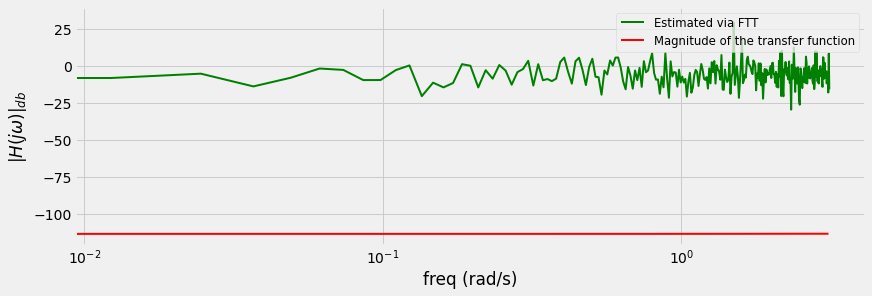

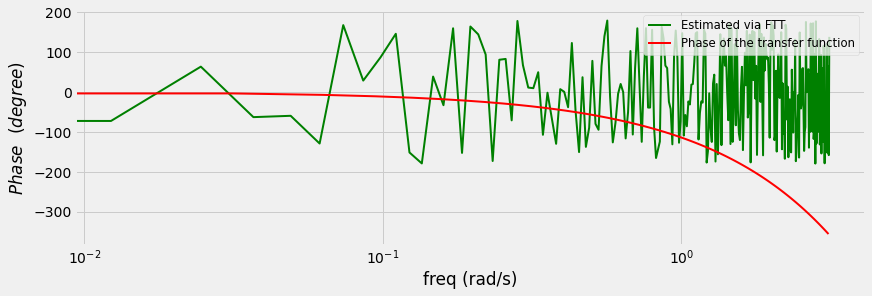

In [55]:
N = 512
u = prbs_signal(N,10,1)
u = u - 0.5
u = np.squeeze(u)
lu = len(u)
t, y = signal.dlsim(tf, u)
y = np.squeeze(y)
e = np.random.rand(N)
Y = fft(y+e)
U = fft(u)
H = Y/U

freq = 1/len(y)*np.arange(0,len(y)/2)*2*math.pi

# Bode estimado a partir das TF dos sinais de entrada e saída
mag_db    = 20*np.log10(abs(H[:len(freq)]))
phase_deg = np.angle(H[:len(freq)])*180/math.pi 

# Bode a partir da função de transferência
w, mag, phase = signal.dlti.bode(tf)

# Plot: Bode da resposta em freq. estimada via FFT e da função de transferência
fig, ax1 = plt.subplots(constrained_layout=True, figsize=(12, 4))    
ax1.set_ylabel('$|H(j\omega)|_{db}$ ')
ax1.set_xlabel('freq (rad/s)')
plt.semilogx(freq,mag_db, color='green', label= 'Estimated via FTT')
plt.semilogx(w, mag, color='red', label= 'Magnitude of the transfer function')
plt.legend(loc='upper right', fontsize = 'small')
plt.grid(True)
fig, ax1 = plt.subplots(constrained_layout=True, figsize=(12, 4))    
ax1.set_ylabel('$Phase ~~(degree)$ ')
ax1.set_xlabel('freq (rad/s)')
plt.semilogx(freq,phase_deg, color='green', label= 'Estimated via FTT')
plt.semilogx(w, phase, color='red', label= 'Phase of the transfer function') 
plt.legend(loc='upper right', fontsize = 'small')
plt.show()                


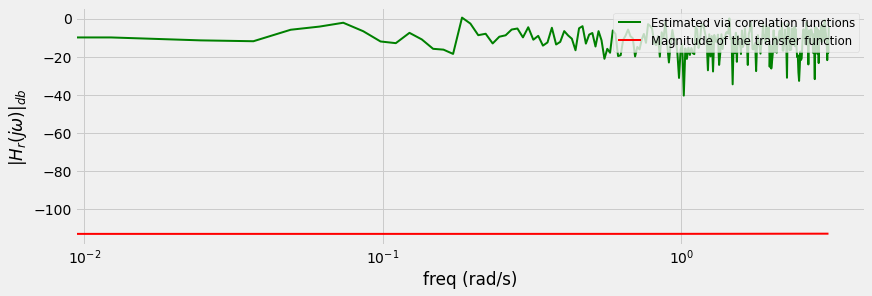

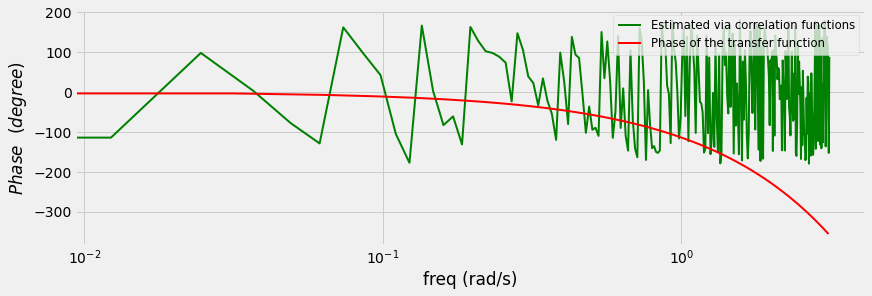

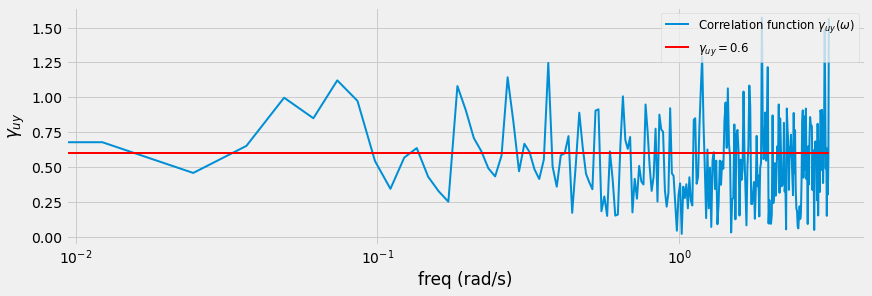

In [57]:
t, ruy, l, Buy = myccf(y+e,u,N,0,0,legend = "cross-correlation")
Ruy=fft(ruy*Buy);
Ruy = np.squeeze(Ruy)
#
t, ruu, l, Buu = myccf(u,u,N,0,0,legend = "autocorrelation")
Ruu=fft(ruu*Buu);
Ruu = np.squeeze(Ruu)
#
t, ryy, l, Byy = myccf(y+e,y+e,N,0,0,legend = "autocorrelation")
Ryy=fft(ryy*Byy);
Ryy = np.squeeze(Ryy)
# Resposta em frequência a partir das funções de correlação
Hr=Ruy/Ruu;
# Bode
Hr_mag_db    = 20*np.log10(abs(Hr[:len(freq)]))
Hr_phase_deg = np.angle(Hr[:len(freq)])*180/math.pi 

# Calculo da funcao de coerencia
guy=np.sqrt((abs(Ruy)**2)/(abs(Ruu)*abs(Ryy)))


# Plot: Bode da resposta em freq. estimada via funções de correlação
fig, ax1 = plt.subplots(constrained_layout=True, figsize=(12, 4))    
ax1.set_ylabel('$|H_r(j\omega)|_{db}$ ')
ax1.set_xlabel('freq (rad/s)')
plt.semilogx(freq,Hr_mag_db, color='green', label= 'Estimated via correlation functions')
plt.semilogx(w, mag, color='red', label= 'Magnitude of the transfer function')
plt.legend(loc='upper right', fontsize = 'small')
plt.grid(True)
fig, ax1 = plt.subplots(constrained_layout=True, figsize=(12, 4))    
ax1.set_ylabel('$Phase ~~(degree)$ ')
ax1.set_xlabel('freq (rad/s)')
plt.semilogx(freq,Hr_phase_deg, color='green', label= 'Estimated via correlation functions')
plt.semilogx(w, phase, color='red', label= 'Phase of the transfer function') 
plt.legend(loc='upper right', fontsize = 'small')
plt.show()   

#Plot
fig, ax1 = plt.subplots(constrained_layout=True, figsize=(12, 4))    
ax1.set_ylabel('$\gamma_{uy}$')
ax1.set_xlabel('freq (rad/s)')
plt.semilogx(freq,guy[0:len(freq)], label= 'Correlation function $\gamma_{uy}(\omega)$') 
plt.semilogx([freq[0], freq[-1]],[0.6, 0.6], color='red', label= '$\gamma_{uy}=0.6$')
plt.legend(loc='upper right', fontsize = 'small')
plt.show()  

# Referência
[Trabalho de referência](http://www.ppgee.ufpa.br/ARQUIVOS/teses/TD%2020_2018%20Florindo%20Ant%C3%B4nio%20de%20Carvalho%20Ayres%20Junior.pdf)

[Trabalho de referência 1](http://www.pee.coppe.ufrj.br/index.php/pt/producao-academica/dissertacoes-de-mestrado/2009-1/2009092801-2009092801/file)

[Modelagem de Processos Químicos](https://issuu.com/modelagemsimulacao/docs/0.0_qm8710_2s_2018)

[Tanques Acoplados](https://www.researchgate.net/publication/281295139_Sistema_de_Tanques_Acoplados_e_Desacoplados_STADpara_o_Estudo_de_Controle_e_Automacao_de_Processos_Modelagem_e_Controle)

[Software de Modelagem EMSO](https://pt.slideshare.net/kaiquest/simulador-de-processos-emso)

[Controle e Sistemas](ftp://ftp.dca.fee.unicamp.br/pub/docs/vonzuben/ea932_03/aulas/topico7_03.pdf)

